In [281]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cluster
from sklearn.metrics import silhouette_score
import statsmodels.api as sm

Import dataset

In [282]:
data = pd.read_csv('house_sales.csv')
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3.0,1.00,1180.0,5650.0,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3.0,2.25,2570.0,7242.0,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2.0,1.00,770.0,10000.0,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4.0,3.00,1960.0,5000.0,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3.0,2.00,1680.0,8080.0,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Describe the dataset. 

In [283]:
data.shape

(21613, 21)

There are 21,613 rows and 21 columns. 

In [284]:
data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,20479.000000,20545.000000,20503.000000,2.056900e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.372821,2.113507,2081.073697,1.517982e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930711,0.768913,915.043176,4.148617e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.500000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1920.000000,7.620000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.070800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,12050.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


Check for nulls. 

In [285]:
data.isna().sum()

id                  0
date                0
price               0
bedrooms         1134
bathrooms        1068
sqft_living      1110
sqft_lot         1044
floors              0
waterfront          0
view                0
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated        0
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

bedrooms, bathrooms, sqft_living, and sqft_lot contain nulls.  

Check for outliers. Let's start with the date column.

In [286]:
columns_with_outliers = set() 

In [287]:
type(data.date[0])

str

The values in the date column are strings. We should convert them to dates. 

In [288]:
data['date'] = data.apply(lambda row: pd.to_datetime(row.date), axis=1)
data['date']

0       2014-10-13
1       2014-12-09
2       2015-02-25
3       2014-12-09
4       2015-02-18
           ...    
21608   2014-05-21
21609   2015-02-23
21610   2014-06-23
21611   2015-01-16
21612   2014-10-15
Name: date, Length: 21613, dtype: datetime64[ns]

In [289]:
data['date'] = data['date'].dt.date
data['date']

0        2014-10-13
1        2014-12-09
2        2015-02-25
3        2014-12-09
4        2015-02-18
            ...    
21608    2014-05-21
21609    2015-02-23
21610    2014-06-23
21611    2015-01-16
21612    2014-10-15
Name: date, Length: 21613, dtype: object

In [290]:
data.date.min(), data.date.max()

(datetime.date(2014, 5, 2), datetime.date(2015, 5, 27))

All of the dates are within 2014 and 2015, as expected. Let's move on to price. 

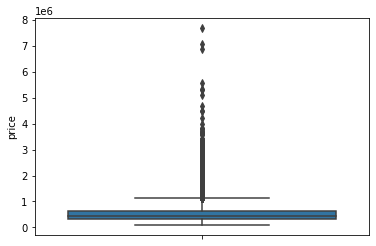

In [291]:
sns.boxplot(data=data, y='price')
plt.show()

There are many price outliers that right-skew the distribution. Let's add it to our set of columns with outliers. And look at bedrooms. 

In [292]:
columns_with_outliers.add('price')

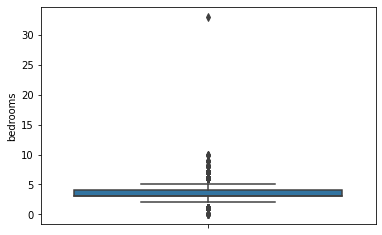

In [293]:
sns.boxplot(data=data, y='bedrooms')
plt.show()

There are bedrooms outliers so let's add it to our set and look at bathrooms. 

In [294]:
columns_with_outliers.add('bedrooms')

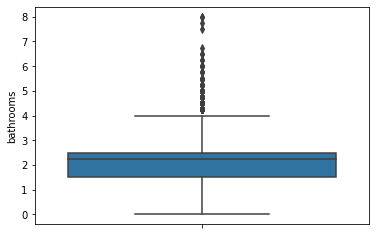

In [295]:
sns.boxplot(data=data, y='bathrooms')
plt.show()

There are bathrooms outliers so let's add it to our set and look at sqft_living.

In [296]:
columns_with_outliers.add('bathrooms')

Let's now take a look at sqft_living. 

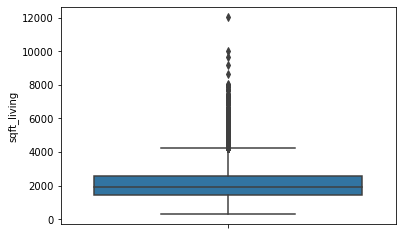

In [297]:
sns.boxplot(data=data, y='sqft_living')
plt.show()

There are sqft_living outliers so let's add it to our set and look at sqft_lot. 

In [298]:
columns_with_outliers.add('sqft_living')

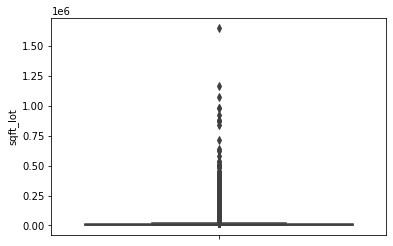

In [299]:
sns.boxplot(data=data, y='sqft_lot')
plt.show()

This distribution is extremely right-skewed with many outliers. Let's add it to our set and look at floors.

In [300]:
columns_with_outliers.add('sqft_lot')

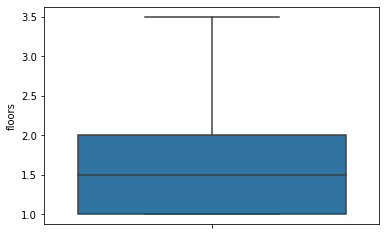

In [301]:
sns.boxplot(data=data, y='floors')
plt.show()

There are no floors outliers so let's move on. waterfront is a binary variable with a max of 1 so no outliers there. view is supposed to be a binary variable but the max is 4, so it must have some data errors. 

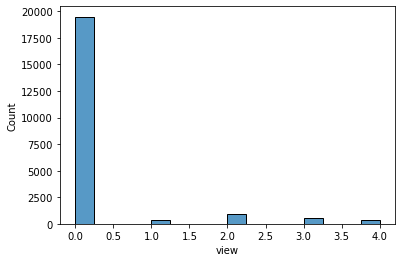

In [302]:
sns.histplot(data.view)
plt.show()

Some view values are 2, 3, and 4. Let's add this to our set but make sure we treat it differently when it comes time to actually identify outliers. 

In [303]:
columns_with_outliers.add('view')

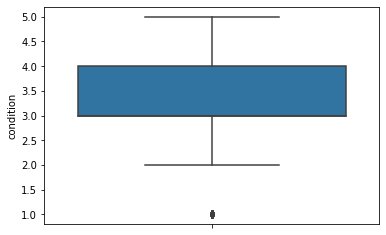

In [304]:
sns.boxplot(data=data, y='condition')
plt.show()

Condition has outliers so let's add it to our set and look at sqft_above.

In [305]:
columns_with_outliers.add('condition')

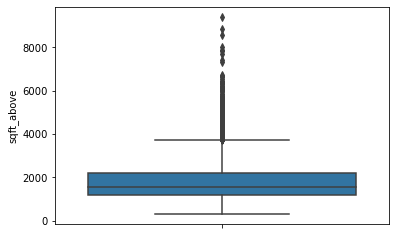

In [306]:
sns.boxplot(data=data, y='sqft_above')
plt.show()

sqft_above has outliers so let's add it to our set and look at sqft_basement.

In [307]:
columns_with_outliers.add('sqft_above')

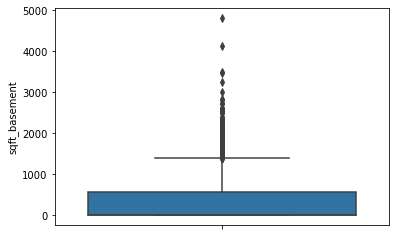

In [308]:
sns.boxplot(data=data, y='sqft_basement')
plt.show()

sqft_basement has outliers so let's add it to our set and look at yr_built.

In [309]:
columns_with_outliers.add('sqft_basement')

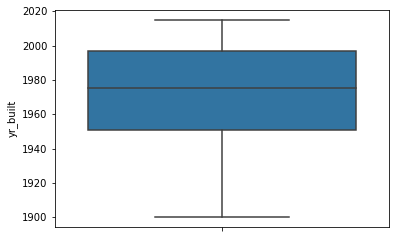

In [310]:
sns.boxplot(data=data, y='yr_built')
plt.show()

No yr_built outliers. Let's look at yr_renovated. Homes that have not been renovated have a value of 0. Let's replace these with nulls so they don't skew the distribution. 

In [311]:
data.yr_renovated.replace(0, np.nan, inplace=True)

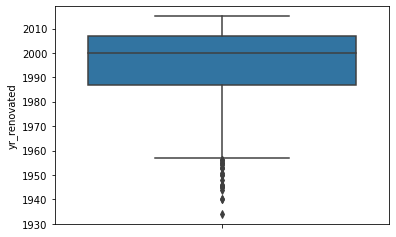

In [312]:
sns.boxplot(data=data, y='yr_renovated')
plt.show()

There are some outliers so let's add this to our set and look at zipcode. 

In [313]:
columns_with_outliers.add('yr_renovated')

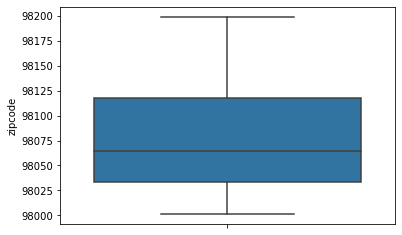

In [314]:
sns.boxplot(data=data, y='zipcode')
plt.show()

No zipcode outliers so let's move on to sqft_living15. 

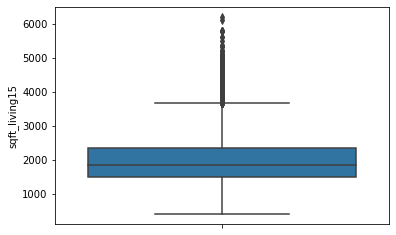

In [315]:
sns.boxplot(data=data, y='sqft_living15')
plt.show()

It has outliers so let's add it to our set and look at sqft_lot15. 

In [316]:
columns_with_outliers.add('sqft_living15')

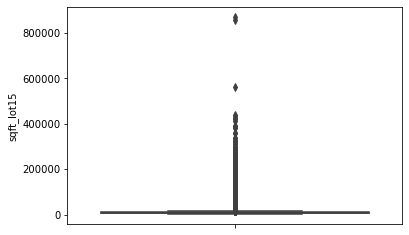

In [317]:
sns.boxplot(data=data, y='sqft_lot15')
plt.show()

There are some very extreme outliers so let's add this column to our set as well. 

In [318]:
columns_with_outliers.add('sqft_lot15')

In [319]:
columns_with_outliers

{'bathrooms',
 'bedrooms',
 'condition',
 'price',
 'sqft_above',
 'sqft_basement',
 'sqft_living',
 'sqft_living15',
 'sqft_lot',
 'sqft_lot15',
 'view',
 'yr_renovated'}

In [320]:
def get_outliers(column):
    if column == 'view': # special logic to handle the view column 
        return data[data.view > 1]
    q1 = data[column].quantile(.25) 
    q3 = data[column].quantile(.75)
    iqr = q3 - q1
    return data[(data[column] < q1 - 1.5 * iqr) | (data[column] > q3 + 1.5 * iqr)]

In [321]:
def consolidate_outliers(columns): 
    outlier_dfs = [] # list to store the dataframe with each column's outliers 
    for c in columns: # for each column 
        df = get_outliers(c) # get its outliers as a dataframe
        outlier_dfs.append(df) # add that dataframe to the list 
    return pd.concat(outlier_dfs).drop_duplicates() # vertically combine the dataframes and drop duplicate rows

In [322]:
outliers = consolidate_outliers(columns_with_outliers)
outliers.shape

(5242, 21)

Our consolidated, deduped dataframe of outliers from all columns has 4,348 houses. Let's remove them from our dataset. 

In [323]:
data = data.merge(
    outliers,
    how='outer',
    indicator=True
).query('_merge == "left_only"').drop('_merge', axis=1)
data.shape

(16371, 21)

We have 16,371 rows left after removing the outliers. Now let's remove the columns that we will not use to model price: 
- id: The unique id of each house is not relevant for modeling sale price. 
- grade: This score is derived from many of the other variables in the dataset, so any information it provides about home price is redundant. 

In [324]:
data.drop(['id', 'grade'], axis=1, inplace=True)

zipcode is a categorical variable with 70 unique values. We'll need to dummify it if we're going to include it in our model. But 69 binary variables is a lot, so first we should check whether zipcode is at all informative of price. 

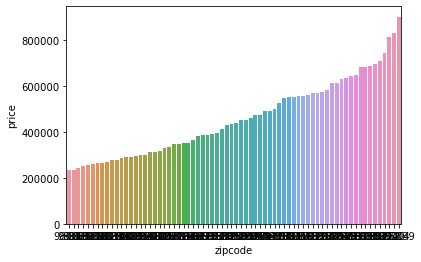

In [325]:
mean_price_by_zipcode = data.groupby(['zipcode'])[['price']].mean().reset_index()
sns.barplot(
    data=mean_price_by_zipcode, 
    x='zipcode', 
    y='price', 
    order=mean_price_by_zipcode.sort_values('price').zipcode
)
plt.show()

It looks like there's quite a lot of variance in price across zipcodes, so zipcode could be helpful in predicting a home's sell price. 

Let's try clustering homes on latitude and longitude to see if we can capture location information with fewer categories. Let's start by plotting lat and long and coloring by price. 

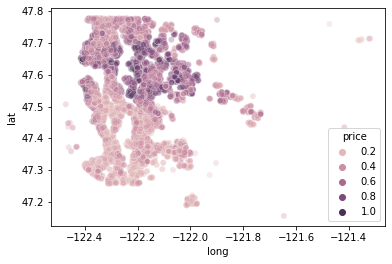

In [326]:
sns.scatterplot(data=data, x='long', y='lat', hue='price', alpha=0.3)
plt.show()

It looks like houses in the north tend to be pricier than those in the south. Let's try clustering on geo coordinates using the K Means algorithm. 

We don't know which number of clusters is optimal so we'll have to iteratively test out different values. 

In [327]:
coords = data[['long', 'lat']].values # store lat and long as a numpy array
k_clusters = np.arange(2, 21) # we'll be testing 2 to 20 clusters 
sse_scores = [] 
silhouette_scores = []
for k in k_clusters: # for each number of clusters 
    kmeans = cluster.KMeans(n_clusters=k, random_state=5) # instantiate a K Means with that many clusters
    kmeans.fit(coords) # fit it to the coordinates 
    sse_scores.append(kmeans.inertia_) # record its Sum of Squared Errors 
    silhouette_scores.append(silhouette_score(coords, kmeans.labels_)) # record its Silhouette Score 

In [328]:
# store the scores for each k calculated above in a dataframe for easy plotting 
kmeans_scores = pd.DataFrame({
    'k': k_clusters,
    'SSE': sse_scores,
    'Silhouette Coefficient': silhouette_scores
})

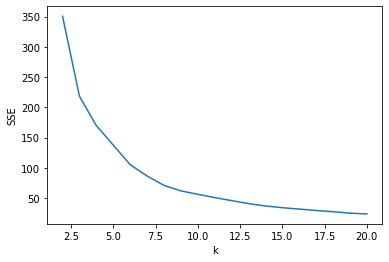

In [329]:
sns.lineplot(data=kmeans_scores, x='k', y='SSE')
plt.show()

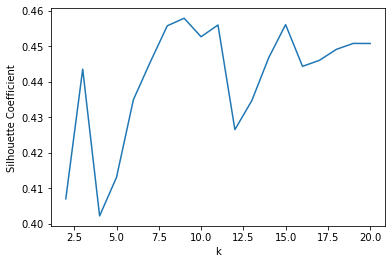

In [330]:
sns.lineplot(data=kmeans_scores, x='k', y='Silhouette Coefficient')
plt.show()

Using the Elbow Method we can see that the SSE curve's inflection is around k=8. We also see that the Silhouette Coefficient's maximum occurs at k=8. These metrics' corroboration gives us confidence to move forward with 8 clusters. 

In [331]:
kmeans = cluster.KMeans(n_clusters=8, random_state=5).fit(coords)
data['cluster'] = kmeans.labels_ # store the homes' cluster labels as a column in our dataset 

Let's plot our geo clusters and see how they look. 

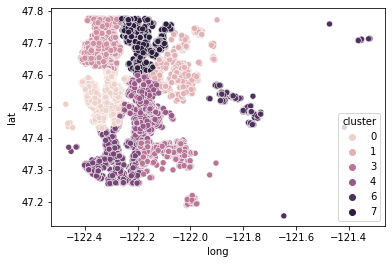

In [332]:
sns.scatterplot(data=data, x='long', y='lat', hue='cluster')
plt.show()

Looks pretty good! But do they correlate with price? Let's regress price on our clusters to find out. To do that we first need to dummify our clusters. 

In [333]:
cluster_dummies = pd.get_dummies(
    data.cluster, 
    drop_first=True, 
    prefix='cluster'
)
cluster_dummies.head()

,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7
0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0


In [334]:
exog = sm.add_constant(cluster_dummies)
endog = data.price
lm = sm.OLS(endog, exog).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     927.7
Date:                Wed, 07 Apr 2021   Prob (F-statistic):               0.00
Time:                        22:28:41   Log-Likelihood:            -2.1958e+05
No. Observations:               16371   AIC:                         4.392e+05
Df Residuals:                   16363   BIC:                         4.392e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.953e+05   2983.190    132.494      0.000    3.89e+05    4.01e+05
cluster_1   1.749e+05   4809.847     36.372      0.000    1.66e+05    1.84e+05
cluster_2   1.382e+05   3927.157     35.180      0.000     1.3e+05    1.46e+05
cluster_3  -9.532e+04   5279.471    -18.054      0.000   -1.06e+05    -8.5e+04
cluster_4   3.204e+04   4556.308      7.033      0.000    2.31e+04     4.1e+04
cluster_5  -1.289e+05   4903.142    -26.295      0.000   -1.39e+05   -1.19e+05
cluster_6   3.638e+04   8766.907      4.149      0.000    1.92e+04    5.36e+04
cluster_7    1.47e+05   4773.579     30.793      0.000    1.38e+05    1.56e+05
==============================================================================
Omnibus:                     2166.475   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3337.158
Skew:                           0.947   Prob(JB):                         0.00
Kurtosis:                       4.142   Cond. No.                         8.37
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Our geo clusters alone explain 28.4% of variance in home price. Not bad! Let's add them to the rest of our data and give them more intuitive names. 

In [335]:
data = pd.concat([data, cluster_dummies], axis=1)
data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_living15,sqft_lot15,cluster,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7
0,2014-10-13,221900.0,3.0,1.00,1180.0,5650.0,1.0,0,0,3,...,1340,5650,0,0,0,0,0,0,0,0
1,2014-12-09,538000.0,3.0,2.25,2570.0,7242.0,2.0,0,0,3,...,1690,7639,2,0,1,0,0,0,0,0
2,2015-02-25,180000.0,2.0,1.00,770.0,10000.0,1.0,0,0,3,...,2720,8062,7,0,0,0,0,0,0,1
3,2014-12-09,604000.0,4.0,3.00,1960.0,5000.0,1.0,0,0,5,...,1360,5000,0,0,0,0,0,0,0,0
4,2015-02-18,510000.0,3.0,2.00,1680.0,8080.0,1.0,0,0,3,...,1800,7503,1,1,0,0,0,0,0,0


In [345]:
data.rename(
    columns={
        'cluster_1': 'northeast',
        'cluster_2': 'northwest',
        'cluster_3': 'southeast',
        'cluster_4': 'east_central',
        'cluster_5': 'southwest',
        'cluster_6': 'inland',
        'cluster_7': 'north_central'
    },
    inplace=True
)
data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_living15,sqft_lot15,cluster,northeast,northwest,southeast,east_central,southwest,inland,north_central
0,2014-10-13,221900.0,3.0,1.00,1180.0,5650.0,1.0,0,0,3,...,1340,5650,0,0,0,0,0,0,0,0
1,2014-12-09,538000.0,3.0,2.25,2570.0,7242.0,2.0,0,0,3,...,1690,7639,2,0,1,0,0,0,0,0
2,2015-02-25,180000.0,2.0,1.00,770.0,10000.0,1.0,0,0,3,...,2720,8062,7,0,0,0,0,0,0,1
3,2014-12-09,604000.0,4.0,3.00,1960.0,5000.0,1.0,0,0,5,...,1360,5000,0,0,0,0,0,0,0,0
4,2015-02-18,510000.0,3.0,2.00,1680.0,8080.0,1.0,0,0,3,...,1800,7503,1,1,0,0,0,0,0,0
